In [99]:
import warnings

import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
# from lion_pytorch import Lion

from src.features import build_features_final, utils
from src.models import predict_model
from src.train.train import train, evaluation, prediction_to_csv
from src.data.make_dataset import DatasetLoader
from src.config.config import seed_everything, cfg
from src.visualization.visual import plot_label_counts

warnings.filterwarnings(action='ignore')
seed_everything(cfg.SEED)


def moving_average(df, period):
    """
    데이터프레임에서 이동평균을 구하는 함수
    
    :param df: 이동평균을 계산할 데이터프레임
    :param period: 이동평균의 기간
    :return: 이동평균이 추가된 데이터프레임
    """
    ma = df.rolling(period).mean().fillna(method='bfill')  # 이동평균 계산
    ma.columns = [col + '_MA' + str(period) for col in df.columns]  # 컬럼 이름 변경
    return pd.concat([df, ma], axis=1)  # 데이터프레임 합치기

scaler = MinMaxScaler()

drop_feature = ['type', 'motor_hp', 'air_end_temp', 'motor_rpm', 'motor_temp', 'motor_vibe', 'motor_current',
                'air_inflow', "air_flow_pressure", "current_by_vibration" , "airflow_per_rotation", "air_to_motor_ratio"]
# 데이터 전처리
train_data = pd.read_csv(r'data\raw\train_data.csv')
# add_train = pd.read_csv(r'data/processed/robust.csv')
# train_data = pd.concat([train_data, add_train], axis=0)
# train_data = utils.outlier_z_score_filter_df(train_data, 3.5)
train_data = build_features_final.create_derived_features(train_data)
train_data = train_data.drop(drop_feature, axis=1)

test_data = pd.read_csv(r'data\raw\test_data.csv')
test_data = build_features_final.create_derived_features(test_data)
test_data = test_data.drop(drop_feature, axis=1)
test_data_raw = test_data.copy()

scaled_train_data = scaler.fit_transform(train_data)
scaled_test_data = scaler.transform(test_data)

scaled_train_data_df = pd.DataFrame(scaled_train_data, columns=train_data.columns)
scaled_test_data_df = pd.DataFrame(scaled_test_data, columns=train_data.columns)

period = 9

scaled_train_data_df = moving_average(scaled_train_data_df, period)
scaled_test_data_df = moving_average(scaled_test_data_df, period)

n_features = scaled_train_data_df.shape[1]
print(n_features)

scaled_train_data = scaled_train_data_df.values
scaled_test_data = scaled_test_data_df.values

# 데이터 로더
dataloader = DatasetLoader(scaled_train_data, scaled_test_data)
train_loader, test_loader = dataloader.load

# # 학습 파라미터
# model = predict_model.AutoEncoder(input_dim=n_features, latent_dim=128)
model = predict_model.SingleAutoEncoder(input_dim=n_features, hidden_dim=600)
# model = predict_model.Conv1DAutoencoder()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
# optimizer = Lion(model.parameters(), lr=cfg.LEARNING_RATE)

# 학습
train(train_loader, model, criterion, optimizer)

# 예측
train_prediction, train_cosine = evaluation(train_loader, model)
print(min(train_cosine))
prediction, test_cosine = evaluation(test_loader, model, min(train_cosine))

# 제출W
submission = prediction_to_csv(prediction)


28
Epoch [0/500], Loss: 0.0582549
Epoch [100/500], Loss: 0.0000166
Epoch [200/500], Loss: 0.0000078
Epoch [300/500], Loss: 0.0000054
Epoch [400/500], Loss: 0.0000044
0.9995948076248169
0    6986
1     403
Name: label, dtype: int64


In [100]:
test_data['label'] = prediction
test_data['treshold'] = test_cosine
def no_out(test_data):
    test7342 = test_data[7342:7361]
    no = test7342[test7342['label']==1]
    yes = test7342[test7342['label']==0]
    return yes, no

yes, no = no_out(test_data)

In [101]:
no.describe()

,out_pressure,current_by_airflow,temp_diff,efficiency,volumetric_efficiency,fan_laws_6,performance_index,air_to_power_ratio,mechanical_efficiency,air_density,air_mass_flow,air_inflow_efficiency1,air_inflow_efficiency2,motor_current_efficiency,label,treshold
count,5.0,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.0,5.000000
mean,0.7,14.847528,15.778000,0.013493,0.244045,0.734084,0.000708,0.019276,32.813240,0.244045,0.510998,0.012811,8.687740,3.621499,1.0,0.996624
std,0.0,1.055039,0.857945,0.001255,0.021817,0.002722,0.000066,0.001793,8.711969,0.021817,0.154828,0.001231,1.132809,0.401902,0.0,0.001675
min,0.7,12.960656,14.410000,0.011311,0.206458,0.730078,0.000595,0.016158,25.498811,0.206458,0.388716,0.010865,7.797098,3.162692,1.0,0.995068
25%,0.7,15.297297,15.500000,0.013612,0.248185,0.732541,0.000711,0.019446,26.806764,0.248185,0.407111,0.012421,7.972896,3.216646,1.0,0.995886
50%,0.7,15.304598,16.110000,0.013940,0.248492,0.735235,0.000724,0.019914,28.368382,0.248492,0.432376,0.013219,8.199131,3.803069,1.0,0.996011
75%,0.7,15.318841,16.330000,0.014213,0.254444,0.735942,0.000743,0.020304,37.427218,0.254444,0.569823,0.013558,8.898897,3.907312,1.0,0.996726
max,0.7,15.356250,16.540000,0.014390,0.262646,0.736622,0.000767,0.020557,45.965023,0.262646,0.756965,0.013993,10.570678,4.017775,1.0,0.999429


In [102]:
yes.describe()

,out_pressure,current_by_airflow,temp_diff,efficiency,volumetric_efficiency,fan_laws_6,performance_index,air_to_power_ratio,mechanical_efficiency,air_density,air_mass_flow,air_inflow_efficiency1,air_inflow_efficiency2,motor_current_efficiency,label,treshold
count,14.0,14.000000,14.000000,14.000000,14.000000,14.000000,14.000000,14.000000,14.000000,14.000000,14.000000,14.000000,14.000000,14.000000,14.0,14.000000
mean,0.7,12.946846,16.558571,0.016279,0.284224,0.735879,0.000814,0.023256,38.686844,0.284224,0.637654,0.014216,9.902380,3.679821,0.0,0.999856
std,0.0,0.017177,1.108192,0.002228,0.038882,0.003525,0.000112,0.003183,8.056264,0.038882,0.132883,0.001950,0.881748,0.503361,0.0,0.000092
min,0.7,12.913386,15.060000,0.013598,0.237408,0.731240,0.000681,0.019425,25.693922,0.237408,0.423206,0.011884,8.249575,3.070753,0.0,0.999619
25%,0.7,12.934716,15.682500,0.014522,0.253566,0.733080,0.000726,0.020746,33.201307,0.253566,0.547473,0.012681,9.541442,3.279112,0.0,0.999806
50%,0.7,12.947241,16.510000,0.015904,0.277675,0.735630,0.000795,0.022719,39.890588,0.277675,0.656516,0.013889,10.260669,3.600375,0.0,0.999879
75%,0.7,12.962207,17.407500,0.017813,0.311043,0.738523,0.000891,0.025446,45.131500,0.311043,0.744796,0.015555,10.565744,4.025967,0.0,0.999896
max,0.7,12.969697,18.210000,0.019872,0.346890,0.741231,0.000994,0.028388,48.353317,0.346890,0.797689,0.017354,10.627214,4.492516,0.0,0.999990


In [103]:
def plot_label_counts(predictions, chunk_sizes):
    for i, (start, end) in enumerate(chunk_sizes):
        chunk = predictions[start:end]
        num_labels = len(chunk[chunk['label'] == 1])
        print(f"Chunk {i}: {num_labels} labels with value 1")
        plt.plot(chunk['label'])
        plt.show()

Chunk 0: 151 labels with value 1


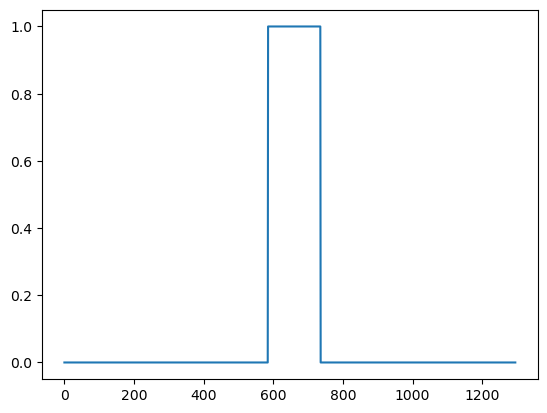

Chunk 1: 0 labels with value 1


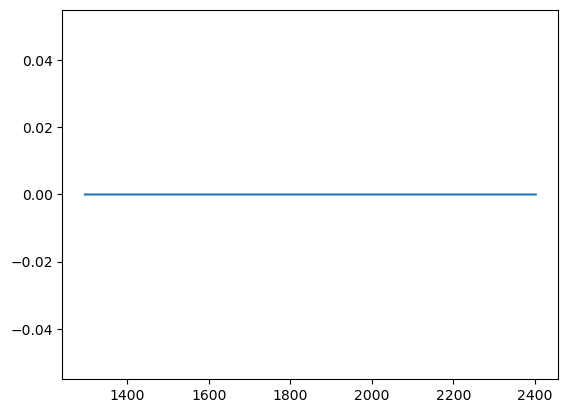

Chunk 2: 34 labels with value 1


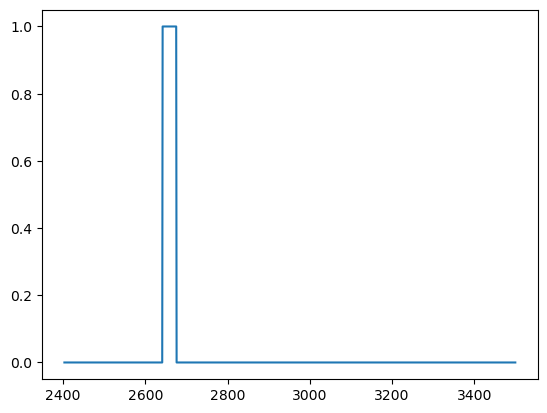

Chunk 3: 33 labels with value 1


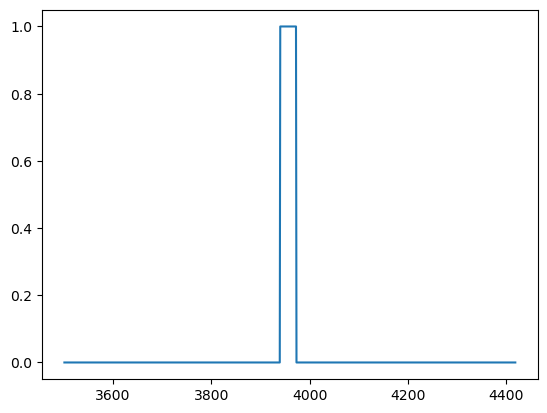

Chunk 4: 29 labels with value 1


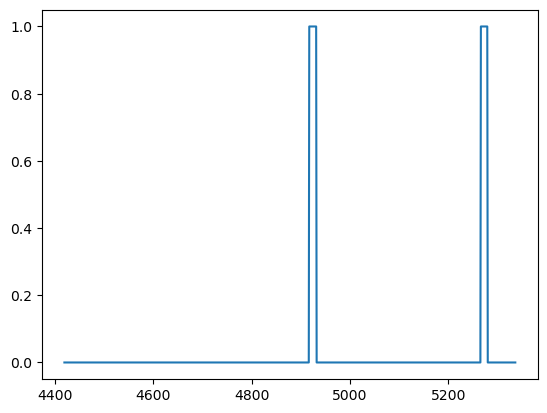

Chunk 5: 29 labels with value 1


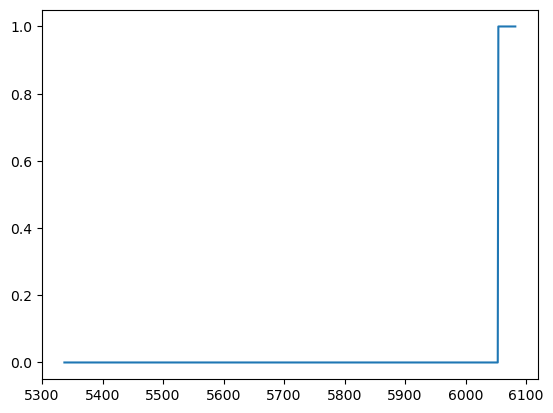

Chunk 6: 117 labels with value 1


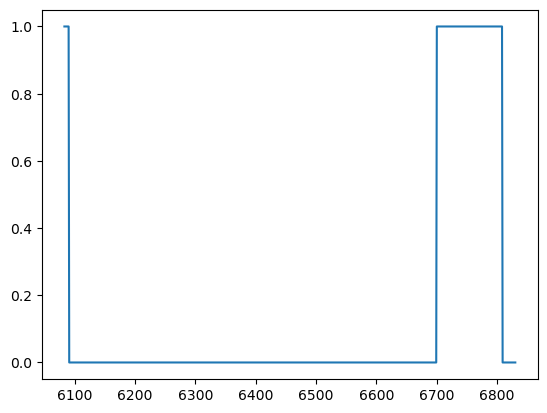

Chunk 7: 10 labels with value 1


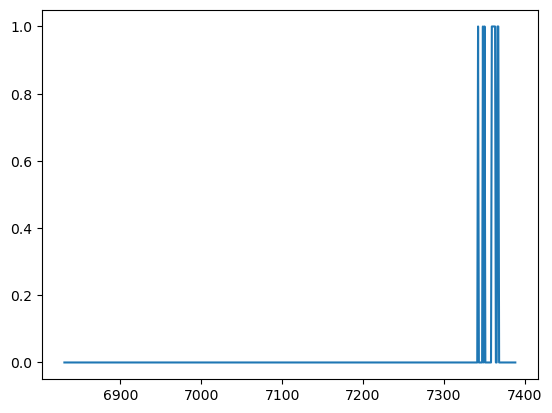

In [104]:
ranges = [(0, 1296), (1296, 2403), (2403, 3501), (3501, 4419), (4419, 5337), (5337, 6083), (6083, 6831), (6831, len(prediction))]
plot_label_counts(submission, ranges)